# 1 Introduction

Welcome to the Playground - Season 3, Episode 5! Looks like we are dealing with a new metric for this episode: [Quadratic Kappa](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html). The data this time is a based on the original [Wine Quality Dataset](https://www.kaggle.com/datasets/yasserh/wine-quality-dataset). 



# 1.1 - First Impressions

Let's load up the data and take a very general look at the dataset.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

import warnings
warnings.filterwarnings('ignore')

train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

train

,Id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0,8.0,0.50,0.39,2.20,0.073,30.0,39.0,0.99572,3.33,0.77,12.1,6
1,1,9.3,0.30,0.73,2.30,0.092,30.0,67.0,0.99854,3.32,0.67,12.8,6
2,2,7.1,0.51,0.03,2.10,0.059,3.0,12.0,0.99660,3.52,0.73,11.3,7
3,3,8.1,0.87,0.22,2.60,0.084,11.0,65.0,0.99730,3.20,0.53,9.8,5
4,4,8.5,0.36,0.30,2.30,0.079,10.0,45.0,0.99444,3.20,1.36,9.5,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2051,2051,6.6,0.31,0.13,2.00,0.056,29.0,42.0,0.99388,3.52,0.87,12.0,7
2052,2052,9.7,0.59,0.21,1.80,0.079,27.0,65.0,0.99745,3.14,0.58,9.4,5
2053,2053,7.7,0.43,0.42,1.70,0.071,19.0,37.0,0.99258,3.32,0.77,12.5,8
2054,2054,9.1,0.50,0.00,1.75,0.058,5.0,13.0,0.99670,3.22,0.42,9.5,5


Okay, so we have some interesting sets of features here to work with. Most of them appear to be continuous in nature. The `quality` feature is what we are attempting to predict, which appears to be categorical in nature. There are only 2,056 rows of data to work on, which is going to be challenging. Let's look at the test set for a moment.

In [5]:
test

,Id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,2056,7.2,0.510,0.01,2.0,0.077,31.0,54.0,0.99748,3.39,0.59,9.8
1,2057,7.2,0.755,0.15,2.0,0.102,14.0,35.0,0.99586,3.33,0.68,10.0
2,2058,8.4,0.460,0.40,2.0,0.065,21.0,50.0,0.99774,3.08,0.65,9.5
3,2059,8.0,0.470,0.40,1.8,0.056,14.0,25.0,0.99480,3.30,0.65,11.7
4,2060,6.5,0.340,0.32,2.1,0.044,8.0,94.0,0.99356,3.23,0.48,12.8
...,...,...,...,...,...,...,...,...,...,...,...,...
1367,3423,8.8,0.745,0.18,2.7,0.084,41.0,115.0,0.99823,3.38,0.70,9.8
1368,3424,15.6,0.240,0.55,2.9,0.062,11.0,25.0,0.99724,2.99,0.77,10.1
1369,3425,7.3,0.760,0.00,2.2,0.095,6.0,19.0,0.99880,3.67,0.60,9.4
1370,3426,7.6,0.780,0.26,2.6,0.118,17.0,104.0,0.99616,3.30,0.53,9.9


So there are 1,372 rows of test data to look at. Overall, we're dealing with a very small dataset size, which is probably to our advantage, since it means it fits into memory nicely without too many problems.

### Key Observations About Initial Impressions

* Overall we have a small dataset to work with.
    * Memory pressure will not be a problem with complex models.
* With 2,056 rows of training data, we may run into problems depending on how the ratings balance works out.

# 1.2 - Class Imbalance

This time around, we're dealing with multiple classes instead of a simple binary classifier. Given that these are ratings on some sort of scale, we may not even want to look at this from the point of view of a classifier, but instead frame this as a regression problem (more about this later). For now, let's assume we have classes, and check on the generalized class breakdown.

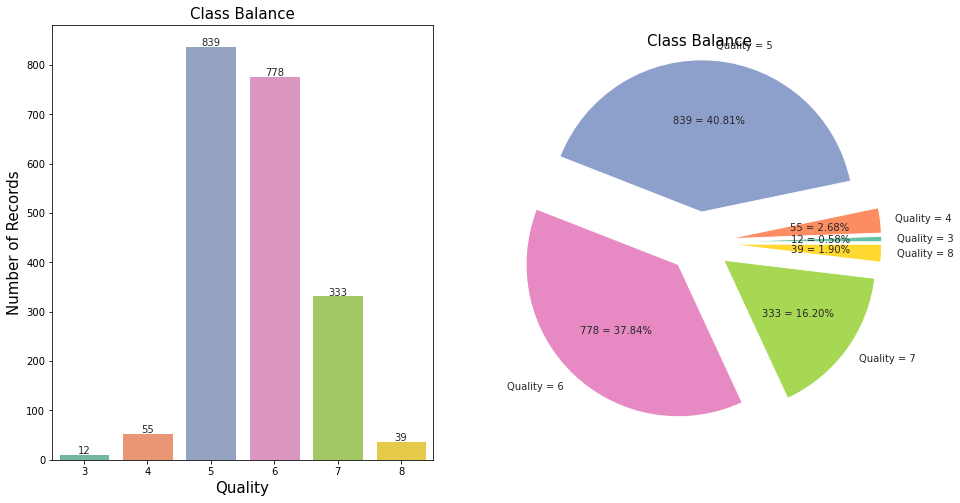

In [3]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

sns.set_style('darkgrid')
sns.set_palette('Set2')

counts = pd.DataFrame(train["quality"].value_counts())
_ = sns.barplot(x=counts.index, y=counts.quality, ax=axs[0])
for p in axs[0].patches:
    axs[0].text(x=p.get_x()+(p.get_width()/2), y=p.get_height(), s="{:,d}".format(round(p.get_height())), ha="center")
_ = axs[0].set_title("Class Balance", fontsize=15)
_ = axs[0].set_ylabel("Number of Records", fontsize=15)
_ = axs[0].set_xlabel("Quality", fontsize=15)

data = [
    train[(train["quality"] == 3)]["Id"].count(),
    train[(train["quality"] == 4)]["Id"].count(),
    train[(train["quality"] == 5)]["Id"].count(),
    train[(train["quality"] == 6)]["Id"].count(),
    train[(train["quality"] == 7)]["Id"].count(),
    train[(train["quality"] == 8)]["Id"].count(),
]
_ = axs[1].pie(
    data, labels=["Quality = 3", "Quality = 4", "Quality = 5", "Quality = 6", "Quality = 7", "Quality = 8"],
    autopct=lambda x: "{:,.0f} = {:.2f}%".format(x * sum(data)/100, x),
    explode=[0.20] * len(data), 
    colors=sns.color_palette("Set2")[0:len(data)],
)
_ = axs[1].set_title("Class Balance", fontsize=15)

### Key Observations About Class Balance

* The majority of the `quality` rankings are 5 or 6, which means just using 5 as a quality metric will likely get a reasonable quadratic kappa metric from it.
* We have very few instances of rankings 3, 4, or 8.
    * These rare cases are going to be difficult to score properly.
* The `quality` rating does not include any instances of 1 or 2, and does not range above 9.
    * We should ensure any predictions are clipped so they fall between 3 and 8.
* While the `quality` rating appears to be categorical, we may want to approach this as a regression problem and round our value to the nearest integer.

# 1.3 - Null Values

Let's explore the issue of missing values in the dataset to see if there are systemic problems with data representation.

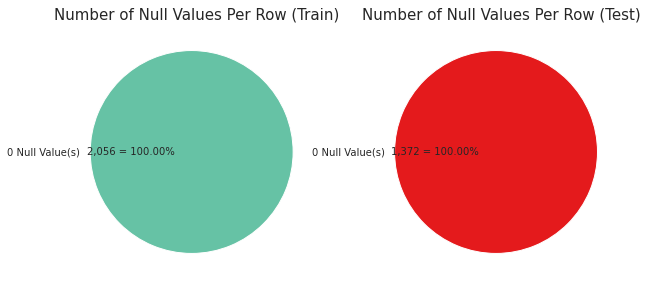

In [4]:
train["null_count"] = train.isnull().sum(axis=1)
counts = train.groupby("null_count")["Id"].count().to_dict()
null_data = {"{} Null Value(s)".format(k) : v for k, v in counts.items() if k < 8}

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 7))

axs = axs.flatten()

_ = axs[0].pie(
    x=list(null_data.values()), 
    autopct=lambda x: "{:,.0f} = {:.2f}%".format(x * sum(null_data.values())/100, x),
    explode=[0.05] * len(null_data.keys()), 
    labels=null_data.keys(), 
    colors=sns.color_palette("Set2")[0:3],
)
_ = axs[0].set_title("Number of Null Values Per Row (Train)", fontsize=15)

test["null_count"] = test.isnull().sum(axis=1)
counts = test.groupby("null_count")["Id"].count().to_dict()
null_data = {"{} Null Value(s)".format(k) : v for k, v in counts.items() if k < 8}

_ = axs[1].pie(
    x=list(null_data.values()), 
    autopct=lambda x: "{:,.0f} = {:.2f}%".format(x * sum(null_data.values())/100, x),
    explode=[0.05] * len(null_data.keys()), 
    labels=null_data.keys(), 
    colors=sns.color_palette("Set1")[0:3],
)
_ = axs[1].set_title("Number of Null Values Per Row (Test)", fontsize=15)

train = train.drop("null_count", axis=1)
test = test.drop("null_count", axis=1)

As in previous episodes, we don't see any null values appearing in our data. This is good.

### Key Observations About Null Values

* No null values appear in the training or testing datasets.

# 1.4 - Train / Test Difference - Adversarial Validation

As a quick test, we should see how different the values are between train and test. To do so, we'll quickly perform a round of adversarial validation to see if a classifier can tell the two datasets apart. We'll use ROC AUC score to inform us of differences. If the two sets appear very similar, the classifier will not be able to tell them apart, and thus will have an ROC AUC score of 0.5. If they are easy to tell apart - and thus are dissimilar - then the ROC AUC score will approach 1.

-------> Fold 1 <--------
: AUC ROC = 0.5284131174261215
-------> Fold 2 <--------
: AUC ROC = 0.5105994249059942
-------> Fold 3 <--------
: AUC ROC = 0.54423800044238
-------> Fold 4 <--------
: AUC ROC = 0.5641083701848792
-------> Fold 5 <--------
: AUC ROC = 0.5299341112117499
--> Overall results for out of fold predictions
: AUC ROC = 0.5315382128393326


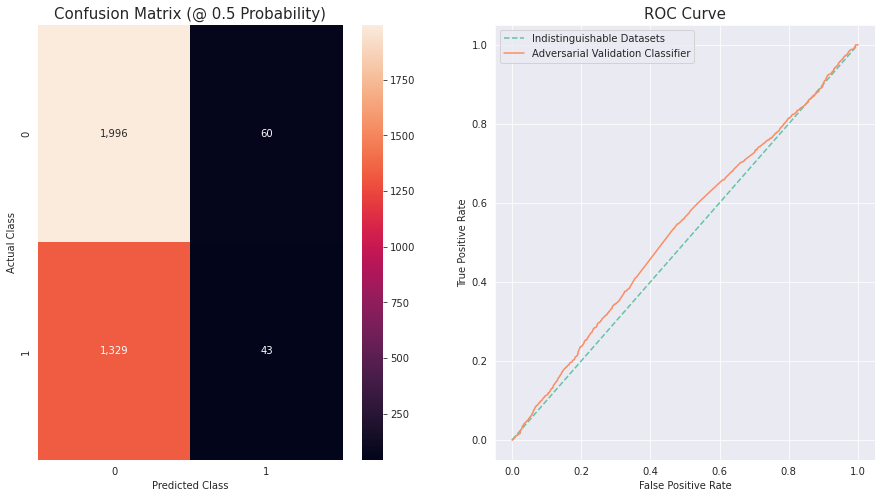

In [5]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from lightgbm import early_stopping, log_evaluation
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import roc_curve

train["origin"] = 0
test["origin"] = 1

combined = train.copy()
combined = pd.concat([combined, test]).reset_index(drop=True)

features = [
    'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 
    'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 
    'pH', 'sulphates', 'alcohol'
]

n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, random_state=2023, shuffle=True)
train_oof_preds = np.zeros((combined.shape[0],))
train_oof_probas = np.zeros((combined.shape[0],))

for fold, (train_index, test_index) in enumerate(skf.split(combined, combined["origin"])):
    print("-------> Fold {} <--------".format(fold + 1))
    x_train, x_valid = pd.DataFrame(combined.iloc[train_index]), pd.DataFrame(combined.iloc[test_index])
    y_train, y_valid = combined["origin"].iloc[train_index], combined["origin"].iloc[test_index]
    
    x_train_features = pd.DataFrame(x_train[features])
    x_valid_features = pd.DataFrame(x_valid[features])

    model = LGBMClassifier(
        random_state=2023,
        objective="binary",
        metric="auc",
        n_jobs=-1,
        n_estimators=2000,
        verbose=-1,  
        max_depth=3,
    )
    model.fit(
        x_train_features[features], 
        y_train,
        eval_set=[(x_valid_features[features], y_valid)],
        callbacks=[
            early_stopping(50, verbose=False),
            log_evaluation(2000),
        ]
    )
    oof_preds = model.predict(x_valid_features[features])
    oof_probas = model.predict_proba(x_valid_features[features])[:,1]
    train_oof_preds[test_index] = oof_preds
    train_oof_probas[test_index] = oof_probas
    print(": AUC ROC = {}".format(roc_auc_score(y_valid, oof_probas)))
    
auc_vanilla = roc_auc_score(combined["origin"], train_oof_probas)
fpr, tpr, _ = roc_curve(combined["origin"], train_oof_probas)
print("--> Overall results for out of fold predictions")
print(": AUC ROC = {}".format(auc_vanilla))

confusion = confusion_matrix(combined["origin"], train_oof_preds)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

_ = sns.heatmap(confusion, annot=True, fmt=",d", ax=axs[0])
_ = axs[0].set_title("Confusion Matrix (@ 0.5 Probability)", fontsize=15)
_ = axs[0].set_ylabel("Actual Class")
_ = axs[0].set_xlabel("Predicted Class")

_ = sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", label="Indistinguishable Datasets", ax=axs[1])
_ = sns.lineplot(x=fpr, y=tpr, ax=axs[1], label="Adversarial Validation Classifier")
_ = axs[1].set_title("ROC Curve", fontsize=15)
_ = axs[1].set_xlabel("False Positive Rate")
_ = axs[1].set_ylabel("True Positive Rate")

### Key Observations About Train / Test Difference - Adversarial Validation

* The trained classifier has an ROC AUC score of 0.5315, which suggests that the training dataset and the testing dataset are very similar.

# 1.5 - Statistical Breakdown

Let's take a closer look at some of the statistical properties of the continuous features. Let's start with the training set.

In [6]:
train[features].describe().T.style.bar(subset=['mean'], color='#7BCC70')\
    .background_gradient(subset=['std'], cmap='Reds')\
    .background_gradient(subset=['50%'], cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
fixed acidity,2056.000000,8.365175,1.705390,5.000000,7.200000,7.950000,9.200000,15.900000
volatile acidity,2056.000000,0.527601,0.173164,0.180000,0.390000,0.520000,0.640000,1.580000
citric acid,2056.000000,0.265058,0.188267,0.000000,0.090000,0.250000,0.420000,0.760000
residual sugar,2056.000000,2.398881,0.858824,1.200000,1.900000,2.200000,2.600000,14.000000
chlorides,2056.000000,0.081856,0.023729,0.012000,0.071000,0.079000,0.090000,0.414000
free sulfur dioxide,2056.000000,16.955982,10.009710,1.000000,8.000000,16.000000,24.000000,68.000000
total sulfur dioxide,2056.000000,49.236868,32.961141,7.000000,22.000000,44.000000,65.000000,289.000000
density,2056.000000,0.996748,0.001827,0.990070,0.995600,0.996700,0.997800,1.003690
pH,2056.000000,3.310569,0.142321,2.740000,3.200000,3.310000,3.390000,3.780000
sulphates,2056.000000,0.641308,0.137942,0.390000,0.550000,0.610000,0.720000,1.950000


And now let's look at our test set.

In [7]:
test[features].describe().T.style.bar(subset=['mean'], color='#7BCC70')\
    .background_gradient(subset=['std'], cmap='Reds')\
    .background_gradient(subset=['50%'], cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1372.000000,8.369606,1.664694,4.900000,7.100000,7.900000,9.100000,15.600000
volatile acidity,1372.000000,0.524311,0.176942,0.120000,0.390000,0.500000,0.635000,1.330000
citric acid,1372.000000,0.270569,0.185731,0.000000,0.110000,0.260000,0.420000,0.760000
residual sugar,1372.000000,2.415926,0.921155,1.300000,2.000000,2.200000,2.500000,8.300000
chlorides,1372.000000,0.081307,0.026566,0.012000,0.070000,0.078000,0.087000,0.467000
free sulfur dioxide,1372.000000,17.162536,9.974082,1.000000,8.000000,16.000000,24.000000,68.000000
total sulfur dioxide,1372.000000,49.089286,32.803721,8.000000,23.000000,43.000000,66.000000,165.000000
density,1372.000000,0.996670,0.001822,0.990070,0.995380,0.996600,0.997800,1.003200
pH,1372.000000,3.312223,0.141405,2.740000,3.210000,3.310000,3.390000,4.010000
sulphates,1372.000000,0.647267,0.134792,0.390000,0.550000,0.620000,0.730000,1.620000


### Key Observations About Statistical Breakdown

* The mean is looking very similar for most features, as expected from our adversarial validation (hugely different means would make training and testing sets easily differentiable).
* The min values for each set also look very similar, as does the standard deviation.
* There is some variation between the sets when it comes to maximum values, which suggests that we should look for what effect outliers have on `quality` ratings.

# 1.6 - Spearman Correlation

We should check to see if there is high correlation between our features. Spearman correlation does not make assumptions about distribution types or linearity. With Spearman correlation, we have values that range from -1 to +1. Values around either extreme end mean a neagative or positive correlation respectively, while those around 0 mean no correlation exists.

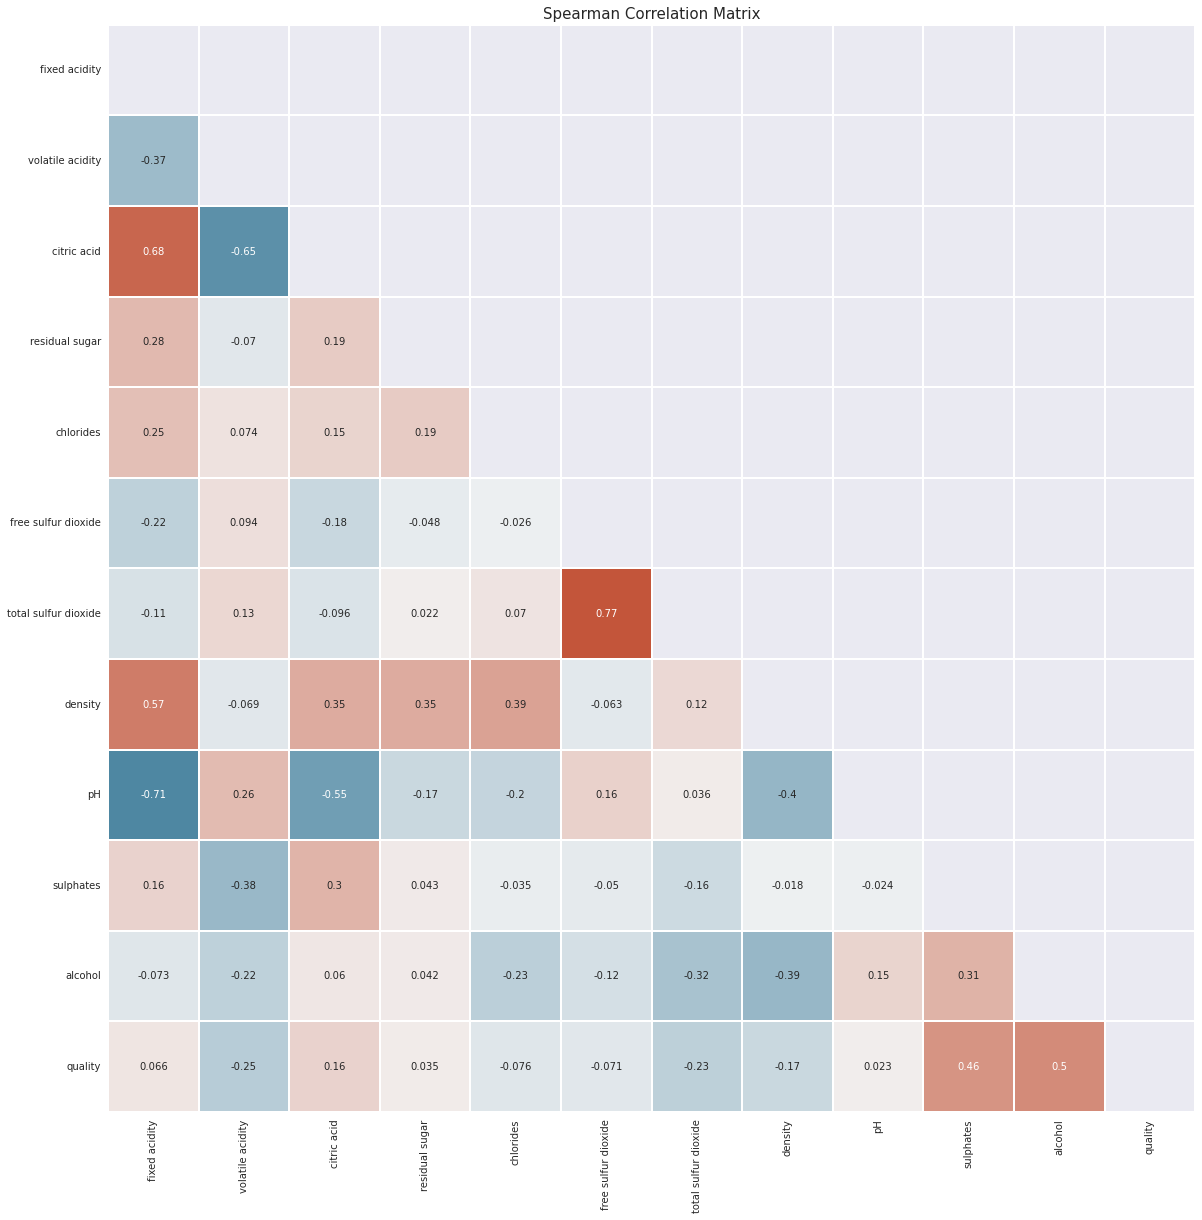

In [8]:
features.append("quality")
correlation_matrix = train[features].corr(method="spearman")

from matplotlib.colors import SymLogNorm

f, ax = plt.subplots(figsize=(20, 20))
_ = sns.heatmap(
    correlation_matrix, 
    mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)), 
    cmap=sns.diverging_palette(230, 20, as_cmap=True), 
    center=0,
    square=True, 
    linewidths=.1, 
    cbar=False,
    ax=ax,
    annot=True,
)
_ = ax.set_title("Spearman Correlation Matrix", fontsize=15)
features.remove("quality")

### Key Observations About Spearman Correlation

* There are some very strong correlations, many of which make sense.
    * The `pH` and `fixed acidity` features have a strong negative correlation, which is expected as both are measures of acidity.
    * The `fixed acidity` and `density` features have a strong positive correlation.
    * The `fixed acidity` and `citric acid` features have a strong positive correlation, which is expected as more citric acid would result in a higher fixed acidity.
    * The `fixed acidity` and `volatile acidity` have a strong negative correlation, which is expected as fixed acidity exists in the wine liquid, while volatile acidity is within the gas of the wine.
* Some strong correlations to the target of `quality` exist with:
    * `volatile acidity` - which suggests smell impacts quality.
    * `alcohol` - which suggests alcohol levels impacts quality.
    * `citric acid` - which suggests that "fresh" flavors or complementary flavors impacts quality.
    * `sulphates` - which suggests that wine color impacts quality.

# 1.7 - Original Data

One thing we can also look at is the original dataset. We will perform an adversarial validation to see whether that dataset is similar to the competition dataset.

-------> Fold 1 <--------
: AUC ROC = 0.6571389030829501
-------> Fold 2 <--------
: AUC ROC = 0.6242575887971611
-------> Fold 3 <--------
: AUC ROC = 0.6032735154432155
-------> Fold 4 <--------
: AUC ROC = 0.6715328467153284
-------> Fold 5 <--------
: AUC ROC = 0.6273423827207922
--> Overall results for out of fold predictions
: AUC ROC = 0.6320769971846905


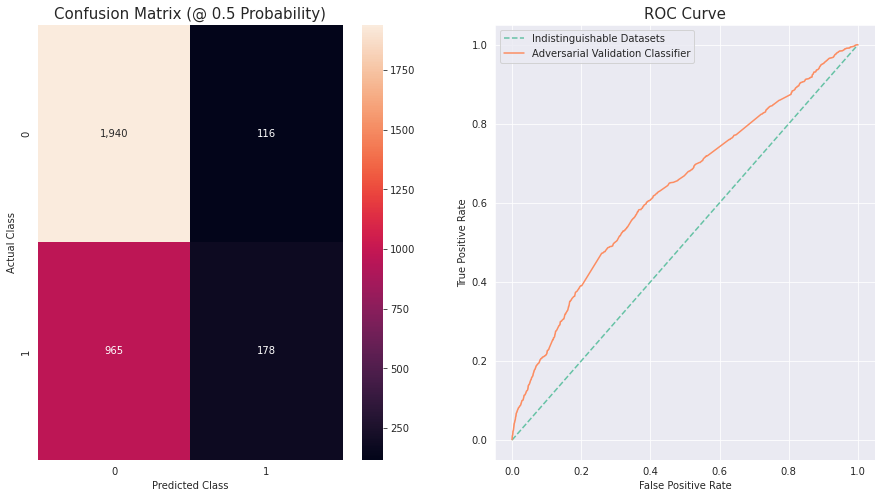

In [9]:
original = pd.read_csv("data/WineQT.csv")

train["origin"] = 0
test["origin"] = 0
original["origin"] = 1

combined = train.copy()
combined = pd.concat([combined, original]).reset_index(drop=True)

features = [
    'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 
    'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 
    'pH', 'sulphates', 'alcohol'
]

n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, random_state=2023, shuffle=True)
train_oof_preds = np.zeros((combined.shape[0],))
train_oof_probas = np.zeros((combined.shape[0],))

for fold, (train_index, test_index) in enumerate(skf.split(combined, combined["origin"])):
    print("-------> Fold {} <--------".format(fold + 1))
    x_train, x_valid = pd.DataFrame(combined.iloc[train_index]), pd.DataFrame(combined.iloc[test_index])
    y_train, y_valid = combined["origin"].iloc[train_index], combined["origin"].iloc[test_index]
    
    x_train_features = pd.DataFrame(x_train[features])
    x_valid_features = pd.DataFrame(x_valid[features])

    model = LGBMClassifier(
        random_state=2023,
        objective="binary",
        metric="auc",
        n_jobs=-1,
        n_estimators=2000,
        verbose=-1,  
        max_depth=3,
    )
    model.fit(
        x_train_features[features], 
        y_train,
        eval_set=[(x_valid_features[features], y_valid)],
        callbacks=[
            early_stopping(50, verbose=False),
            log_evaluation(2000),
        ]
    )
    oof_preds = model.predict(x_valid_features[features])
    oof_probas = model.predict_proba(x_valid_features[features])[:,1]
    train_oof_preds[test_index] = oof_preds
    train_oof_probas[test_index] = oof_probas
    print(": AUC ROC = {}".format(roc_auc_score(y_valid, oof_probas)))
    
auc_vanilla = roc_auc_score(combined["origin"], train_oof_probas)
fpr, tpr, _ = roc_curve(combined["origin"], train_oof_probas)
print("--> Overall results for out of fold predictions")
print(": AUC ROC = {}".format(auc_vanilla))

confusion = confusion_matrix(combined["origin"], train_oof_preds)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

_ = sns.heatmap(confusion, annot=True, fmt=",d", ax=axs[0])
_ = axs[0].set_title("Confusion Matrix (@ 0.5 Probability)", fontsize=15)
_ = axs[0].set_ylabel("Actual Class")
_ = axs[0].set_xlabel("Predicted Class")

_ = sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", label="Indistinguishable Datasets", ax=axs[1])
_ = sns.lineplot(x=fpr, y=tpr, ax=axs[1], label="Adversarial Validation Classifier")
_ = axs[1].set_title("ROC Curve", fontsize=15)
_ = axs[1].set_xlabel("False Positive Rate")
_ = axs[1].set_ylabel("True Positive Rate")

One thing we should consider is whether there are duplicates between the training set and the original dataset. This was brought up in the discussion [Duplicates present between train & original dataset](https://www.kaggle.com/competitions/playground-series-s3e5/discussion/383737)

-------> Fold 1 <--------
: AUC ROC = 0.5763008752211967
-------> Fold 2 <--------
: AUC ROC = 0.6390439387433805
-------> Fold 3 <--------
: AUC ROC = 0.5959937502981728
-------> Fold 4 <--------
: AUC ROC = 0.6129478555412433
-------> Fold 5 <--------
: AUC ROC = 0.6240995769060205
--> Overall results for out of fold predictions
: AUC ROC = 0.6067690615611598


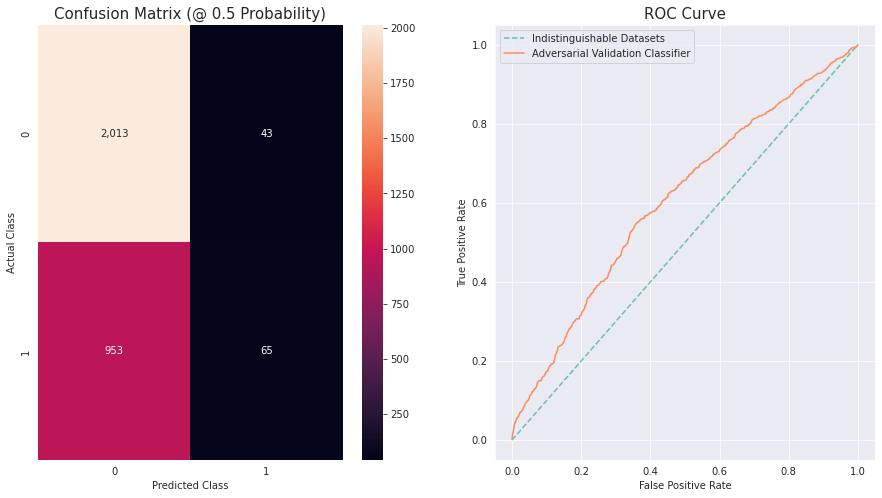

In [10]:
original = pd.read_csv("data/WineQT.csv")

train["origin"] = 0
test["origin"] = 0
original["origin"] = 1

combined = train.copy()
combined = pd.concat([combined, original]).reset_index(drop=True)

features = [
    'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 
    'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 
    'pH', 'sulphates', 'alcohol'
]

combined = combined.drop_duplicates(subset=features)

n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, random_state=2023, shuffle=True)
train_oof_preds = np.zeros((combined.shape[0],))
train_oof_probas = np.zeros((combined.shape[0],))

for fold, (train_index, test_index) in enumerate(skf.split(combined, combined["origin"])):
    print("-------> Fold {} <--------".format(fold + 1))
    x_train, x_valid = pd.DataFrame(combined.iloc[train_index]), pd.DataFrame(combined.iloc[test_index])
    y_train, y_valid = combined["origin"].iloc[train_index], combined["origin"].iloc[test_index]
    
    x_train_features = pd.DataFrame(x_train[features])
    x_valid_features = pd.DataFrame(x_valid[features])

    model = LGBMClassifier(
        random_state=2023,
        objective="binary",
        metric="auc",
        n_jobs=-1,
        n_estimators=2000,
        verbose=-1,  
        max_depth=3,
    )
    model.fit(
        x_train_features[features], 
        y_train,
        eval_set=[(x_valid_features[features], y_valid)],
        callbacks=[
            early_stopping(50, verbose=False),
            log_evaluation(2000),
        ]
    )
    oof_preds = model.predict(x_valid_features[features])
    oof_probas = model.predict_proba(x_valid_features[features])[:,1]
    train_oof_preds[test_index] = oof_preds
    train_oof_probas[test_index] = oof_probas
    print(": AUC ROC = {}".format(roc_auc_score(y_valid, oof_probas)))
    
auc_vanilla = roc_auc_score(combined["origin"], train_oof_probas)
fpr, tpr, _ = roc_curve(combined["origin"], train_oof_probas)
print("--> Overall results for out of fold predictions")
print(": AUC ROC = {}".format(auc_vanilla))

confusion = confusion_matrix(combined["origin"], train_oof_preds)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

_ = sns.heatmap(confusion, annot=True, fmt=",d", ax=axs[0])
_ = axs[0].set_title("Confusion Matrix (@ 0.5 Probability)", fontsize=15)
_ = axs[0].set_ylabel("Actual Class")
_ = axs[0].set_xlabel("Predicted Class")

_ = sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", label="Indistinguishable Datasets", ax=axs[1])
_ = sns.lineplot(x=fpr, y=tpr, ax=axs[1], label="Adversarial Validation Classifier")
_ = axs[1].set_title("ROC Curve", fontsize=15)
_ = axs[1].set_xlabel("False Positive Rate")
_ = axs[1].set_ylabel("True Positive Rate")

### Key Observations About Original Data

* Our classifier had an ROC AUC of 0.6321, meaning that it was easier to identify the original data when mixed with the competition data.
    * There are duplicates between the datasets - removing them resulted in an ROC AUC of 0.6068.
    * More investigation is needed to determine what features make this task easier.
    * We should use caution when utilizing the original dataset, since it is easier to separate the two of them (thus, they are dissimilar).

# 1.8 - P-Value Testing

While looking at features visually will tell us some interesting information, we can also use p-value testing to see if a feature has a net impact on a simple regression model. This method is controversial in that it likely doesn't provide a correct look at what features are informative. Our null hypothesis is that the feature impacts the target variable of `quality`. In this case, anything with a p-value greater than 0.05 means we reject that hypothesis, and can potentially flag it for removal. Based on our current examination thus far, and given how few features we have to work with, it is very likely that all our features are informative.

In [11]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

x = add_constant(train[features])
model = OLS(train["quality"], x).fit()

pvalues = pd.DataFrame(model.pvalues)
pvalues.reset_index(inplace=True)
pvalues.rename(columns={0: "pvalue", "index": "feature"}, inplace=True)
pvalues.style.background_gradient(cmap='YlOrRd')

,feature,pvalue
0,const,0.025534
1,fixed acidity,0.020765
2,volatile acidity,0.264205
3,citric acid,0.741096
4,residual sugar,0.495016
5,chlorides,0.861593
6,free sulfur dioxide,0.003011
7,total sulfur dioxide,0.000198
8,density,0.031832
9,pH,0.565406


### Key Observations About P-Value Testing

* There are several features that could potentially be removed due to p-value:
    * `volatile acidity`
    * `citric acid`
    * `residual sugar`
    * `chlorides`
    * `pH`
* Note that a lot of the above are probably due to the correlations we saw when looking at Spearman Correlation.

# 1.9 - Dimensionality Reduction - UMAP

Given we have a large number of features, we may want to explore reducing the dimensionality of the data to see if there is anything interesting. We can use UMAP (Uniform Manifold Approximation and Projection) to reduce the dataset into a fewer number of dimensions. Similar to a PCA, UMAP attempts to reduce the dimensionality of a dataset by utilizing manifold learning. It's primary purpose is to help visualize what a dataset looks like. Ideally, this reduction in dimensionality may also be of benefit when it comes to machine learning tasks, in this case, potentially giving rise to a classifier with better performance than one that attempts to use the entire dataset. We can use a UMAP reduction and use the reduced features in a machine learning classifier directly.

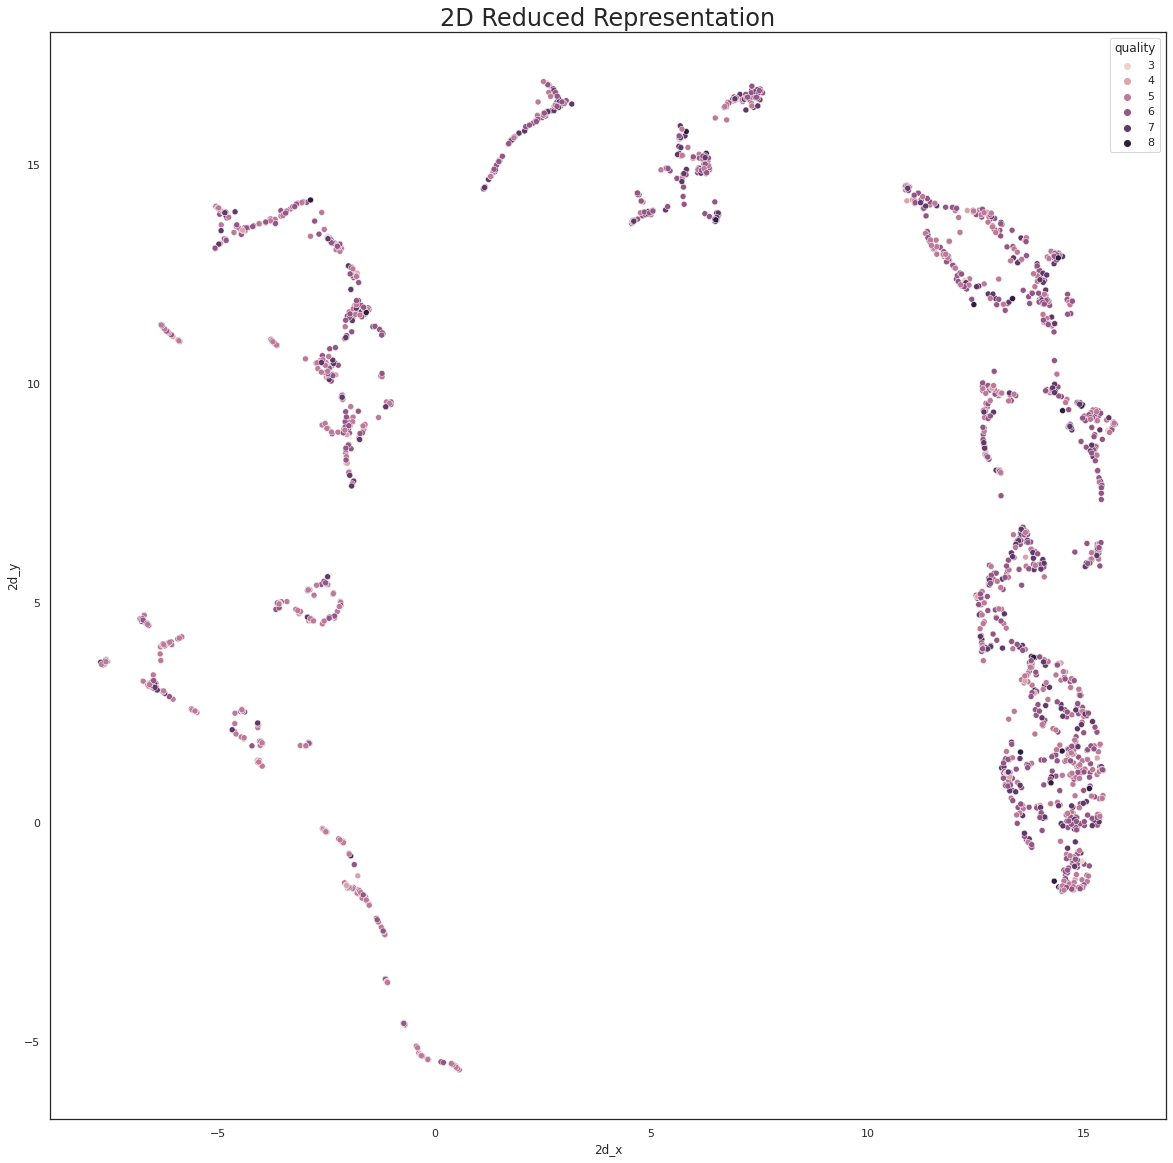

In [12]:
import umap
from category_encoders import LeaveOneOutEncoder

umap_train = train.copy()

reducer = umap.UMAP(random_state=2023)
reduced_data = reducer.fit_transform(umap_train[features])
umap_train["2d_x"] = reduced_data[:, 0]
umap_train["2d_y"] = reduced_data[:, 1]

sns.set(style='white', context='notebook')

f, ax = plt.subplots(figsize=(20, 20))

_ = sns.scatterplot(data=umap_train, x="2d_x", y="2d_y", hue="quality", ax=ax)
_ = ax.set_title('2D Reduced Representation', fontsize=24)

While we are seeing distinct clusters of samples, we're not seeing nice class separation at all, meaning that it's hard to separate out each `quality` ranking from the others. Let's see if a 3 dimensional representation helps.

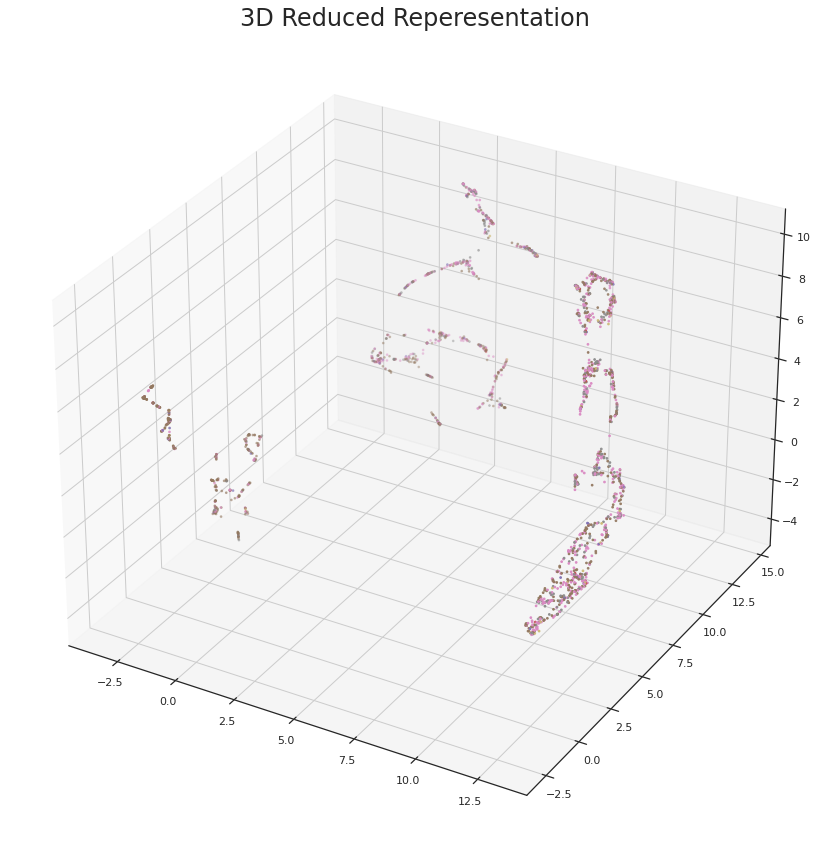

In [13]:
reducer = umap.UMAP(n_components=3, random_state=2023)
reduced_data = reducer.fit_transform(umap_train[features])

fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(projection='3d')

_ = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c=[sns.color_palette()[x] for x in train["quality"]], s=3)
_ = plt.title('3D Reduced Reperesentation', fontsize=24)

### Key Observations About Dimensionality Reduction

* While we can see clusters of samples, the clusters do not appear to be nicely organized by `quality`. We're likely going to have problems separating the data.

# 2 - Feature Exploration

With a broad overview complete, we should look more at the individual features.

# 2.1 - Fixed Acidity

There are two types of acidity found in wine: fixed and volatile (Nierman, 2004). Both types of acid contribute to the flavor of the wine. Too little acid and the wine tastes flat, while too many acids, and the wine will taste sour. The fixed acidity of a wine is the non-volatile acids that generally remain within the liquid itself. This fixed acidity can be due to the grapes, or it can arise as a by-product of fermentation. Either way, a proper balance is required for a good tasting wine.

Overall, from our correlation matrix, fixed acidity provides very poor signal when it comes to predicting quality. Let's take a look to see how the fixed acidity corresponds to the overall ranking.

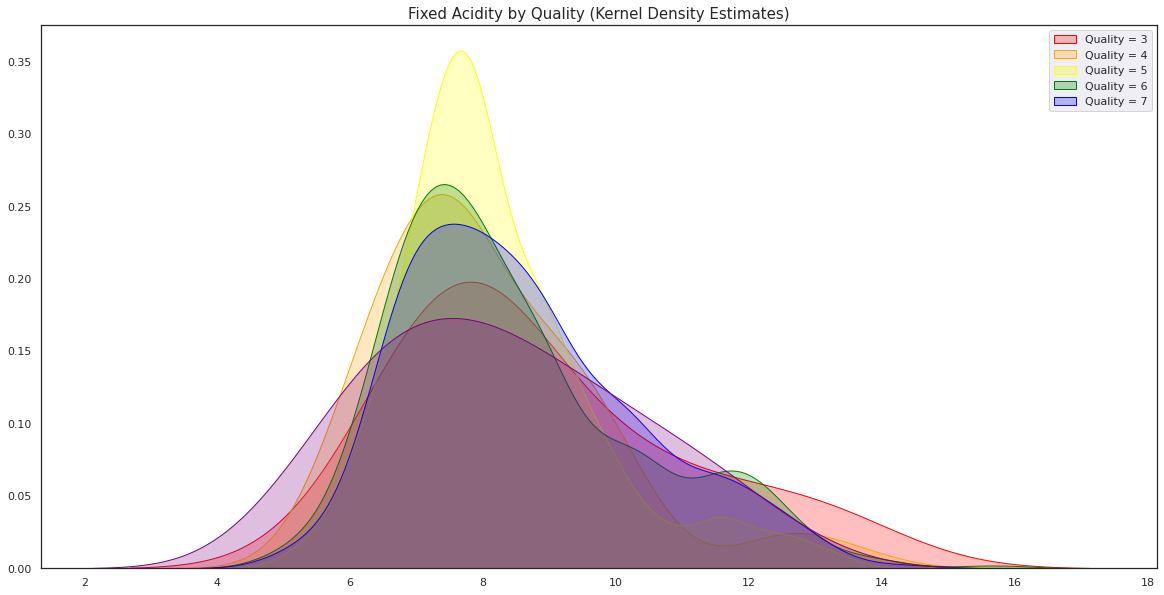

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
sns.set_style('darkgrid')

_ = sns.kdeplot(train[(train["quality"] == 3)]["fixed acidity"], shade=True, color="red", ax=ax, label="Quality = 3")
_ = sns.kdeplot(train[(train["quality"] == 4)]["fixed acidity"], shade=True, color="orange", ax=ax, label="Quality = 4")
_ = sns.kdeplot(train[(train["quality"] == 5)]["fixed acidity"], shade=True, color="yellow", ax=ax, label="Quality = 5")
_ = sns.kdeplot(train[(train["quality"] == 6)]["fixed acidity"], shade=True, color="green", ax=ax, label="Quality = 6")
_ = sns.kdeplot(train[(train["quality"] == 7)]["fixed acidity"], shade=True, color="blue", ax=ax, label="Quality = 7")
_ = sns.kdeplot(train[(train["quality"] == 8)]["fixed acidity"], shade=True, color="purple", ax=ax, label="Quality = 8")
_ = ax.set_title("Fixed Acidity by Quality (Kernel Density Estimates)", fontsize=15)
_ = ax.set_ylabel("")
_ = ax.set_xlabel("")
handles, labels = ax.get_legend_handles_labels()
_ = ax.legend(handles=handles[0:5], labels=["Quality = 3", "Quality = 4", "Quality = 5", "Quality = 6", "Quality = 7", "Quality = 8"], title="")

Okay, digging in a little more, it looks like most of the fixed acidities are centered around 7 or 8, with various qualities having shorter or longer tails. For example, wines with quality of 5 tend to be very tightly clustered in acidity around 7, while wines with a quality of 7 have a wider dispersal. The density estimates are hiding a lot however, so we would be better off using a different visualization strategy. If we quantize the fixed acidity values, we can get a better sense of how they are dispersed. 

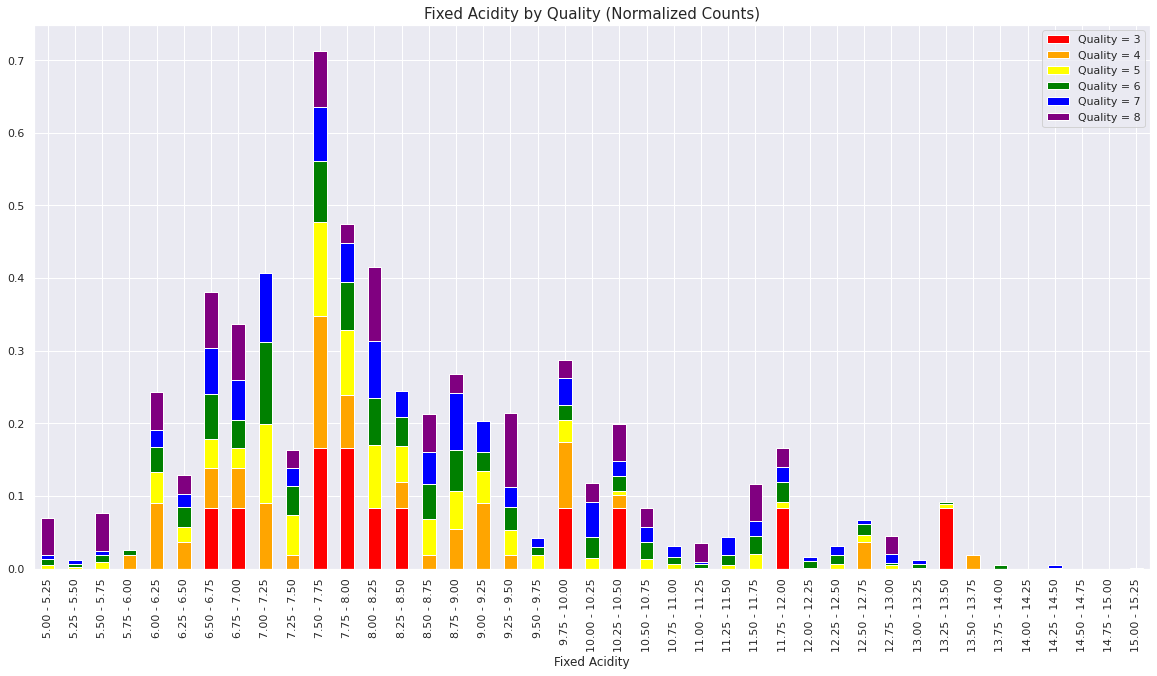

In [15]:
def bin_data(series, bin_defs):
    bins = [0 for _ in range(len(bin_defs))]
    total = 0
    for x in series:
        for index, (bin_min, bin_max) in enumerate(bin_defs):
            if x >= bin_min and x < bin_max:
                bins[index] += 1
                total += 1
                break
    return [float(x / total) if total != 0 else 0 for x in bins]

bin_defs = []
labels = []
z = 5.0
for x in range(int(z), 46):
    bin_defs.append([z, z+0.25])
    labels.append("{:.2f} - {:.2f}".format(z, z+0.25))
    z += 0.25
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))

sns.set_style('darkgrid')
sns.set_palette('Set2')

tdf = pd.DataFrame(
    {
        'Label': labels,
        'Quality = 3': bin_data(train[(train["quality"] == 3)]["fixed acidity"], bin_defs),
        'Quality = 4': bin_data(train[(train["quality"] == 4)]["fixed acidity"], bin_defs),
        'Quality = 5': bin_data(train[(train["quality"] == 5)]["fixed acidity"], bin_defs),
        'Quality = 6': bin_data(train[(train["quality"] == 6)]["fixed acidity"], bin_defs),
        'Quality = 7': bin_data(train[(train["quality"] == 7)]["fixed acidity"], bin_defs),
        'Quality = 8': bin_data(train[(train["quality"] == 8)]["fixed acidity"], bin_defs),
    }
)

_ = tdf.set_index('Label').plot(kind='bar', stacked=True, color=["red", "orange", "yellow", "green", "blue", "purple"], ax=ax)
_ = ax.set_title("Fixed Acidity by Quality (Normalized Counts)", fontsize=15)
_ = ax.set_ylabel("")
_ = ax.set_xlabel("Fixed Acidity")

Now we're starting to see some interesting separation. What we are looking for are areas where ideally 2 or 3 colors are showing without any others. Ideally these color bands would be quality values that are near to each other so our quadratic kappa value doesn't hurt us too much if the classifier mixes them up. Let's summarize some of what we are seeing.

* Higher qualities of wine - 5, 6, 7, and 8 - are separable from lower qualities in the 5.00 - 5.75 range.
* The lowest quality of wine - 3 - is very much "hidden" by most other wines, except in the 13.25 - 13.50 range, where it is a standout.
* For more wine quality groups:
    * Wine of quality 4 is spread out between 5.75 - 10.50.
    * Wine of quality 5 is spread out between 6.00 - 13.50.
    * Wine of quality 6 is spread out between 6.00 - 12.75.
    * Wine of quality 7 is spread out between 6.00 - 13.00.
    * Wine of quality 8 is spread out between 5.00 - 13.00.
    * The large number of overlaps between spreads is what will make distinguishing between wine qualities difficult.
    
The fixed acidity value however, isn't the only story we have when it comes to acidity. Ideally we want to pair fixed acidity with another feature that has a stronger correlation with quality. By doing so, we can boost the signal between the pair of features into a stronger one. Looking at our correlation matrix, volatile acidity also works with fixed acidity to give it flavor, and volatile acidity is more strongly correlated with quality. If we add the two values together, we may see a profile of what a good wine looks like, and separate classes a little bit better.

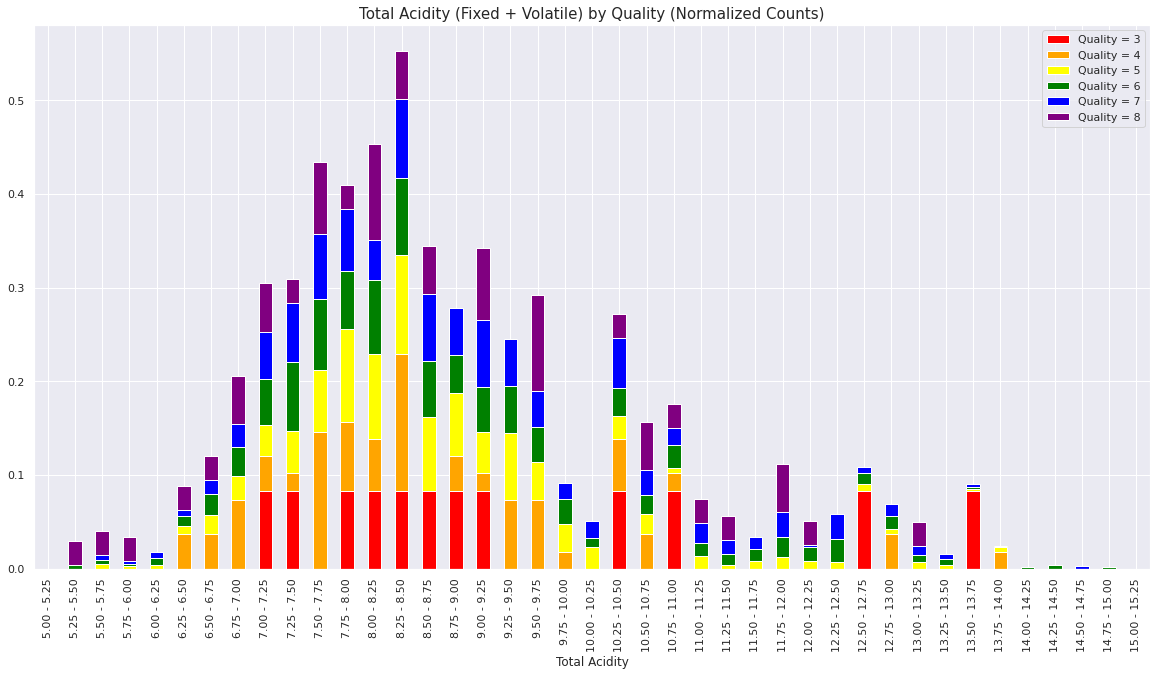

In [16]:
bin_defs = []
labels = []
z = 5.0
for x in range(int(z), 46):
    bin_defs.append([z, z+0.25])
    labels.append("{:.2f} - {:.2f}".format(z, z+0.25))
    z += 0.25
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))

sns.set_style('darkgrid')
sns.set_palette('Set2')

tdf = pd.DataFrame(
    {
        'Label': labels,
        'Quality = 3': bin_data(train[(train["quality"] == 3)]["fixed acidity"] + train[(train["quality"] == 3)]["volatile acidity"], bin_defs),
        'Quality = 4': bin_data(train[(train["quality"] == 4)]["fixed acidity"] + train[(train["quality"] == 4)]["volatile acidity"], bin_defs),
        'Quality = 5': bin_data(train[(train["quality"] == 5)]["fixed acidity"] + train[(train["quality"] == 5)]["volatile acidity"], bin_defs),
        'Quality = 6': bin_data(train[(train["quality"] == 6)]["fixed acidity"] + train[(train["quality"] == 6)]["volatile acidity"], bin_defs),
        'Quality = 7': bin_data(train[(train["quality"] == 7)]["fixed acidity"] + train[(train["quality"] == 7)]["volatile acidity"], bin_defs),
        'Quality = 8': bin_data(train[(train["quality"] == 8)]["fixed acidity"] + train[(train["quality"] == 8)]["volatile acidity"], bin_defs),
    }
)

_ = tdf.set_index('Label').plot(kind='bar', stacked=True, color=["red", "orange", "yellow", "green", "blue", "purple"], ax=ax)
_ = ax.set_title("Total Acidity (Fixed + Volatile) by Quality (Normalized Counts)", fontsize=15)
_ = ax.set_ylabel("")
_ = ax.set_xlabel("Total Acidity")

Now we are starting to see more class separation. Qualities of wine in the range of 5, 6, 7, and 8 are separable at the 11.25 - 12.50 mark, and between 5.25 and 6.25. This is starting to look like there may be some feature engineering possible. 

Another aspect we can look at is whether fixed acidity can interact with other features that are not highly correlated with quality, and boost their respective signals by combining them. Let's look if there is an interaction with `pH`. We saw in our correlation matrix that `fixed acidity` and `pH` shared a very strong negative correlation. Let's multiply the fixed acidity by the pH value.

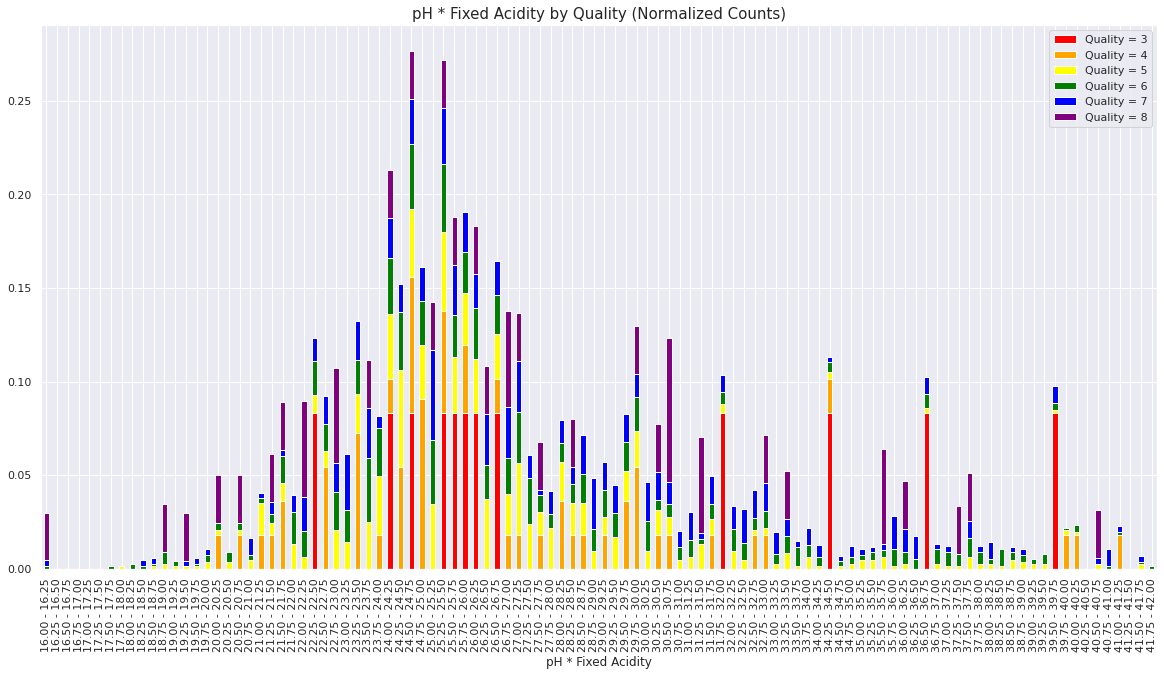

In [17]:
bin_defs = []
labels = []
z = 16.0
step = 0.25
for x in range(int(z), 120):
    bin_defs.append([z, z + step])
    labels.append("{:.2f} - {:.2f}".format(z, z + step))
    z += step
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))

sns.set_style('darkgrid')
sns.set_palette('Set2')

tdf = pd.DataFrame(
    {
        'Label': labels,
        'Quality = 3': bin_data(train[(train["quality"] == 3)]["fixed acidity"] * train[(train["quality"] == 3)]["pH"], bin_defs),
        'Quality = 4': bin_data(train[(train["quality"] == 4)]["fixed acidity"] * train[(train["quality"] == 4)]["pH"], bin_defs),
        'Quality = 5': bin_data(train[(train["quality"] == 5)]["fixed acidity"] * train[(train["quality"] == 5)]["pH"], bin_defs),
        'Quality = 6': bin_data(train[(train["quality"] == 6)]["fixed acidity"] * train[(train["quality"] == 6)]["pH"], bin_defs),
        'Quality = 7': bin_data(train[(train["quality"] == 7)]["fixed acidity"] * train[(train["quality"] == 7)]["pH"], bin_defs),
        'Quality = 8': bin_data(train[(train["quality"] == 8)]["fixed acidity"] * train[(train["quality"] == 8)]["pH"], bin_defs),
    }
)

_ = tdf.set_index('Label').plot(kind='bar', stacked=True, color=["red", "orange", "yellow", "green", "blue", "purple"], ax=ax)
_ = ax.set_title("pH * Fixed Acidity by Quality (Normalized Counts)", fontsize=15)
_ = ax.set_ylabel("")
_ = ax.set_xlabel("pH * Fixed Acidity")

We're getting much more separation out of the qualities 5, 6, and 7 wines at the upper ranges of 34.50 - 39.50. And again, higher quality wines can be separated out between 16.00 - 20.00. This could be a possible engineered feature to provide separation between classes. It may be weak, but it could provide enough additional signal to improve our classifier models.

### Key Observations About Fixed Acidity

* Overall, fixed acidity is a poor predictor of quality on its own.
* By binning (discretizing) our data, we can see where separation is occurring.
    * Binning is unlikely to help our classifier models, as most tree based classifiers can discover this type of separation on their own.
* Some potential engineered features to consider are:
    * Adding volatile acidity to fixed acidity.
    * Multiplying fixed acidity by pH.

# 2.2 - Density

The density of a wine (also known as specific gravity) measures the concentration of sugars that are present in the liquid. The more sugar in the wine, the higher the density. As a wine ages, the active yeast and other microorganisms present in the liquid consume the sugar and converts it to alcohol, and other gaseous by-products (Anonymous, n.d.). A good wine starts out with a density of ~1.090 and continues to ferment until the yeast has consumed an appropriate amount of sugar, with the target being a density of roughly 0.996. Density, by its nature, interacts with sugar levels, as bacteria and yeast consume them throughout the fermentation process.

Let's start by looking at how our densities are aligned with the quality of the wine.

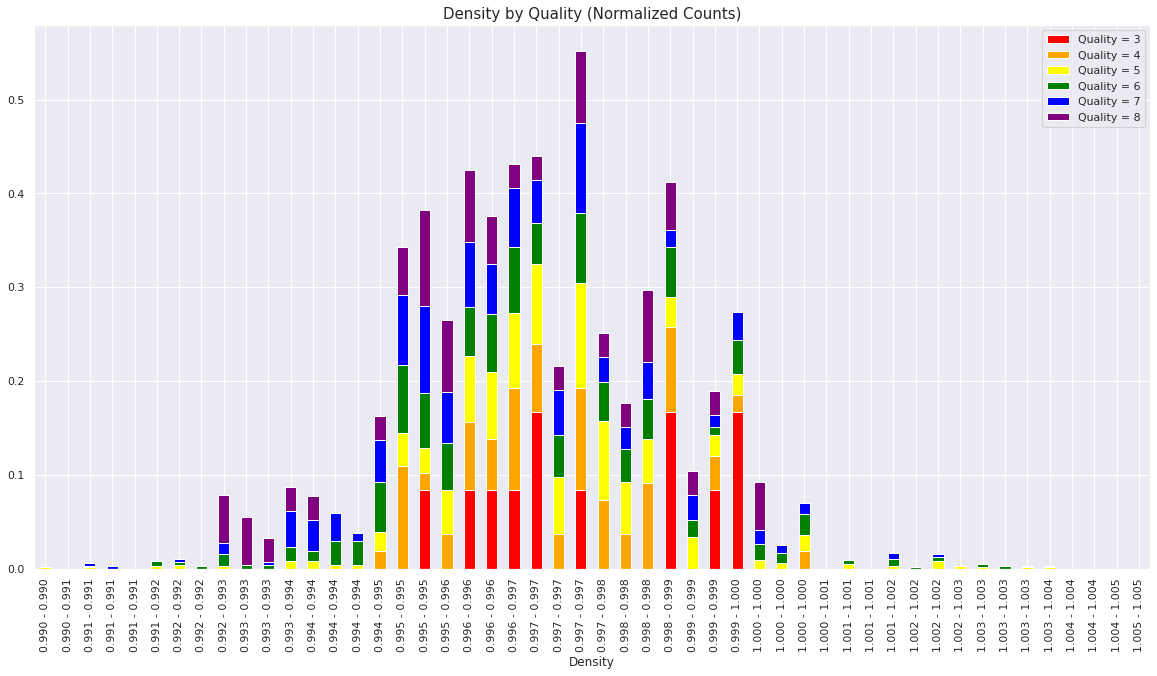

In [18]:
bin_defs = []
labels = []
z = 0.99
step = 0.0003
for x in range(int(z), 50):
    bin_defs.append([z, z + step])
    labels.append("{:.3f} - {:.3f}".format(z, z + step))
    z += step
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))

sns.set_style('darkgrid')
sns.set_palette('Set2')

tdf = pd.DataFrame(
    {
        'Label': labels,
        'Quality = 3': bin_data(train[(train["quality"] == 3)]["density"], bin_defs),
        'Quality = 4': bin_data(train[(train["quality"] == 4)]["density"], bin_defs),
        'Quality = 5': bin_data(train[(train["quality"] == 5)]["density"], bin_defs),
        'Quality = 6': bin_data(train[(train["quality"] == 6)]["density"], bin_defs),
        'Quality = 7': bin_data(train[(train["quality"] == 7)]["density"], bin_defs),
        'Quality = 8': bin_data(train[(train["quality"] == 8)]["density"], bin_defs),
    }
)

_ = tdf.set_index('Label').plot(kind='bar', stacked=True, color=["red", "orange", "yellow", "green", "blue", "purple"], ax=ax)
_ = ax.set_title("Density by Quality (Normalized Counts)", fontsize=15)
_ = ax.set_ylabel("")
_ = ax.set_xlabel("Density")

Much as we saw with fixed acidity, we see separation of the higher quality wines at the lower and upper ends of the density measurements. Again, our purpose with feature engineering would be to see if we can create even more separation so that our classifier has a better chance of properly classifying the wines.

We know that density is related to sugar (density is a direct measurement of sugar in the liquid) as well as alcohol and acidity. Let's see if we can combine these features in a way that will increase the separation between classes. Let's look at sugar interaction with density.

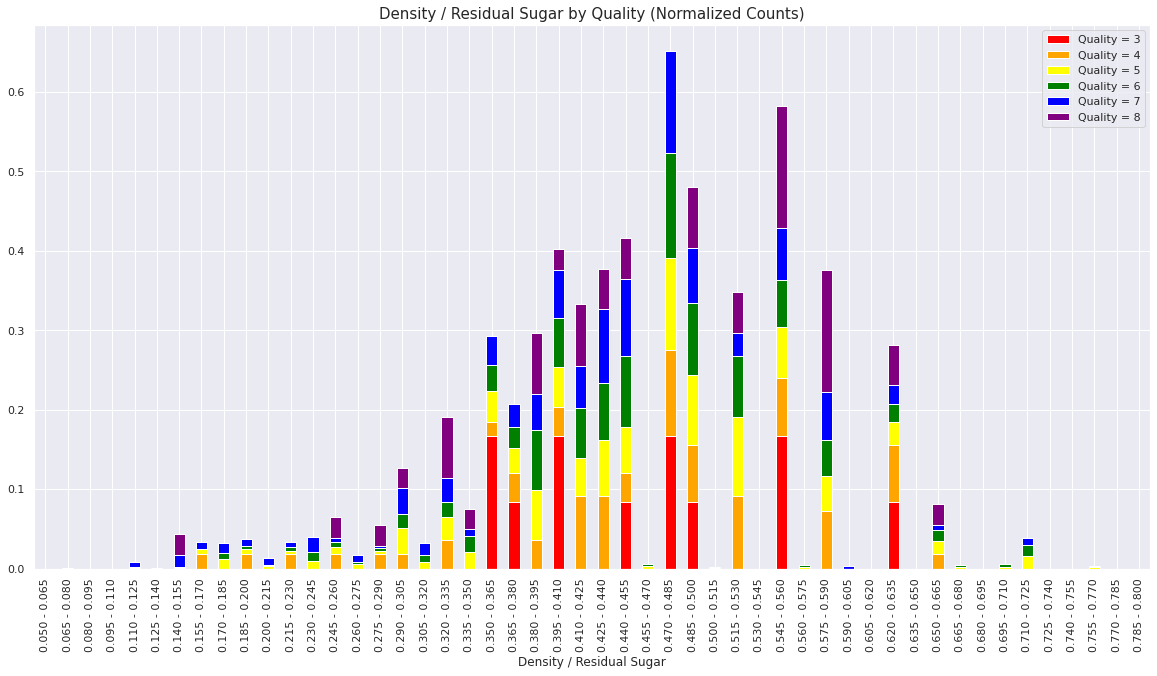

In [19]:
bin_defs = []
labels = []
z = 0.05
step = 0.015
for x in range(int(z), 50):
    bin_defs.append([z, z + step])
    labels.append("{:.3f} - {:.3f}".format(z, z + step))
    z += step
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))

sns.set_style('darkgrid')
sns.set_palette('Set2')

tdf = pd.DataFrame(
    {
        'Label': labels,
        'Quality = 3': bin_data(train[(train["quality"] == 3)]["density"] / train[(train["quality"] == 3)]["residual sugar"], bin_defs),
        'Quality = 4': bin_data(train[(train["quality"] == 4)]["density"] / train[(train["quality"] == 4)]["residual sugar"], bin_defs),
        'Quality = 5': bin_data(train[(train["quality"] == 5)]["density"] / train[(train["quality"] == 5)]["residual sugar"], bin_defs),
        'Quality = 6': bin_data(train[(train["quality"] == 6)]["density"] / train[(train["quality"] == 6)]["residual sugar"], bin_defs),
        'Quality = 7': bin_data(train[(train["quality"] == 7)]["density"] / train[(train["quality"] == 7)]["residual sugar"], bin_defs),
        'Quality = 8': bin_data(train[(train["quality"] == 8)]["density"] / train[(train["quality"] == 8)]["residual sugar"], bin_defs),
    }
)

_ = tdf.set_index('Label').plot(kind='bar', stacked=True, color=["red", "orange", "yellow", "green", "blue", "purple"], ax=ax)
_ = ax.set_title("Density / Residual Sugar by Quality (Normalized Counts)", fontsize=15)
_ = ax.set_ylabel("")
_ = ax.set_xlabel("Density / Residual Sugar")

Again, we see separation between classes. Particularly at the bottom of the range, we see separation of some of the higher qualities. Additionally, there are pockets within that show separation of single classes at the upper ranges as well. Again, this could be a potential engineered features.

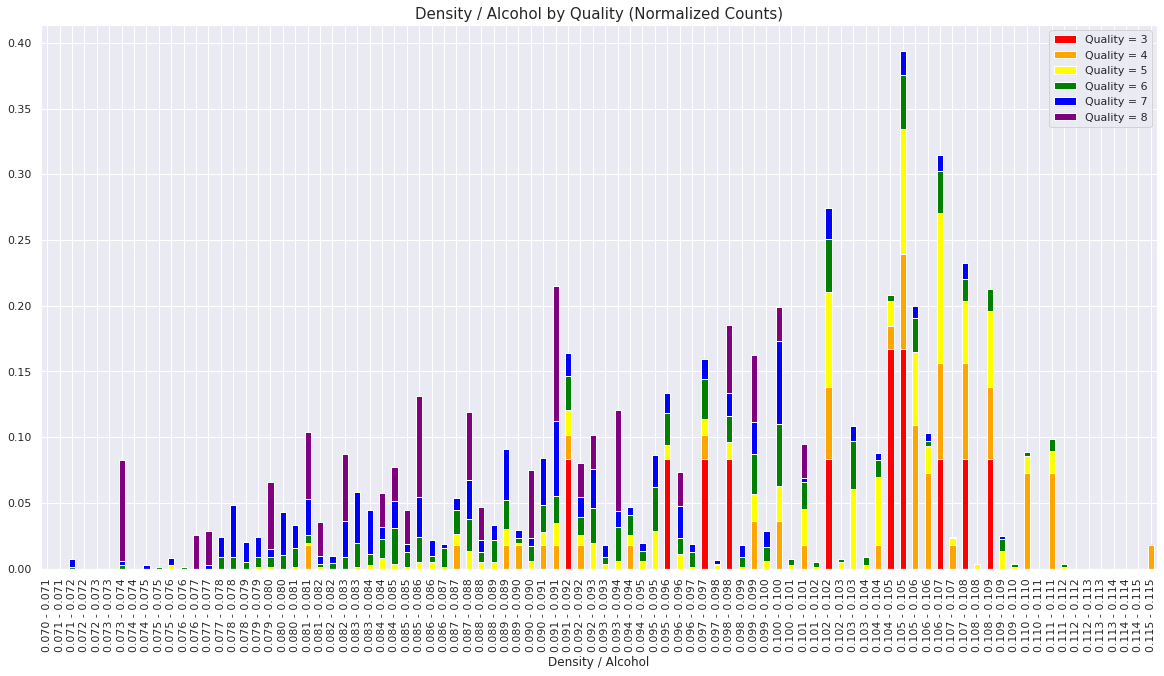

In [20]:
bin_defs = []
labels = []
z = 0.07
step = 0.0005
for x in range(int(z), 90):
    bin_defs.append([z, z + step])
    labels.append("{:.3f} - {:.3f}".format(z, z + step))
    z += step
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))

sns.set_style('darkgrid')
sns.set_palette('Set2')

tdf = pd.DataFrame(
    {
        'Label': labels,
        'Quality = 3': bin_data(train[(train["quality"] == 3)]["density"] / train[(train["quality"] == 3)]["alcohol"], bin_defs),
        'Quality = 4': bin_data(train[(train["quality"] == 4)]["density"] / train[(train["quality"] == 4)]["alcohol"], bin_defs),
        'Quality = 5': bin_data(train[(train["quality"] == 5)]["density"] / train[(train["quality"] == 5)]["alcohol"], bin_defs),
        'Quality = 6': bin_data(train[(train["quality"] == 6)]["density"] / train[(train["quality"] == 6)]["alcohol"], bin_defs),
        'Quality = 7': bin_data(train[(train["quality"] == 7)]["density"] / train[(train["quality"] == 7)]["alcohol"], bin_defs),
        'Quality = 8': bin_data(train[(train["quality"] == 8)]["density"] / train[(train["quality"] == 8)]["alcohol"], bin_defs),
    }
)

_ = tdf.set_index('Label').plot(kind='bar', stacked=True, color=["red", "orange", "yellow", "green", "blue", "purple"], ax=ax)
_ = ax.set_title("Density / Alcohol by Quality (Normalized Counts)", fontsize=15)
_ = ax.set_ylabel("")
_ = ax.set_xlabel("Density / Alcohol")

Here we see very nice separation of quality 8 wines at the lower end of the spectrum, which is important as quality 8 is another rare case. Similar separation of quality 4 occurs at the upper end of the spectrum. Again, this is another potential engineered feature.

Let's take a look at density and total acidity.

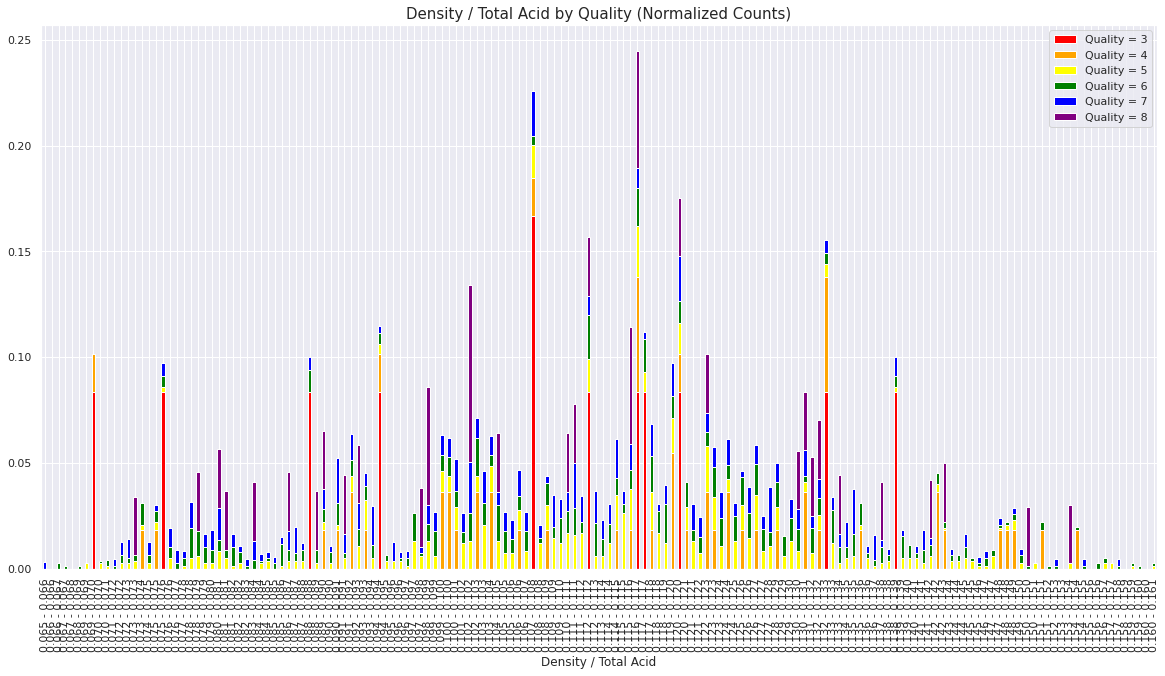

In [21]:
bin_defs = []
labels = []
z = 0.065
step = 0.0006
for x in range(int(z), 160):
    bin_defs.append([z, z + step])
    labels.append("{:.3f} - {:.3f}".format(z, z + step))
    z += step
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))

sns.set_style('darkgrid')
sns.set_palette('Set2')

tdf = pd.DataFrame(
    {
        'Label': labels,
        'Quality = 3': bin_data(train[(train["quality"] == 3)]["density"] / (train[(train["quality"] == 3)]["fixed acidity"] + train[(train["quality"] == 3)]["volatile acidity"] + train[(train["quality"] == 3)]["citric acid"]), bin_defs),
        'Quality = 4': bin_data(train[(train["quality"] == 4)]["density"] / (train[(train["quality"] == 4)]["fixed acidity"] + train[(train["quality"] == 4)]["volatile acidity"] + train[(train["quality"] == 4)]["citric acid"]), bin_defs),
        'Quality = 5': bin_data(train[(train["quality"] == 5)]["density"] / (train[(train["quality"] == 5)]["fixed acidity"] + train[(train["quality"] == 5)]["volatile acidity"] + train[(train["quality"] == 5)]["citric acid"]), bin_defs),
        'Quality = 6': bin_data(train[(train["quality"] == 6)]["density"] / (train[(train["quality"] == 6)]["fixed acidity"] + train[(train["quality"] == 6)]["volatile acidity"] + train[(train["quality"] == 6)]["citric acid"]), bin_defs),
        'Quality = 7': bin_data(train[(train["quality"] == 7)]["density"] / (train[(train["quality"] == 7)]["fixed acidity"] + train[(train["quality"] == 7)]["volatile acidity"] + train[(train["quality"] == 7)]["citric acid"]), bin_defs),
        'Quality = 8': bin_data(train[(train["quality"] == 8)]["density"] / (train[(train["quality"] == 8)]["fixed acidity"] + train[(train["quality"] == 8)]["volatile acidity"] + train[(train["quality"] == 8)]["citric acid"]), bin_defs),
    }
)

_ = tdf.set_index('Label').plot(kind='bar', stacked=True, color=["red", "orange", "yellow", "green", "blue", "purple"], ax=ax)
_ = ax.set_title("Density / Total Acid by Quality (Normalized Counts)", fontsize=15)
_ = ax.set_ylabel("")
_ = ax.set_xlabel("Density / Total Acid")

Again, we're seeing good separation of qualities based on the new feature. 

### Key Observations About Density

* Overall, density is a good indicator of quality.
* Some potential engineered features to consider are:
    * Dividing density by residual sugar.
    * Dividing density by alcohol.
    * Dividing density by total acidity (fixed acidity + volatile acidity + citric acid).

# 2.3 - Sulfur Dioxide

Sulfur dioxide is used to preserve the wine, and prevent it from discoloring due to oxidation (Savits, 2019). So-called free sulfur dioxide is used to preserve the wine, although it is possible that certain amounts become bound to other organic molecules and cease to provide protection. The total sulfur dioxide content comprises both the free and bound sulfur dioxide, and is regulated such that total amounts are not allowed to exceed certain thresholds. Insufficient free sulfur dioxide can lead to spoilage and discoloration of the wine, potentially impacting quality.

Since total sulfur dioxide has a weak negative correlation with quality, let's look at it first, and then see how free sulfur dioxide can be used to leverage class separation.

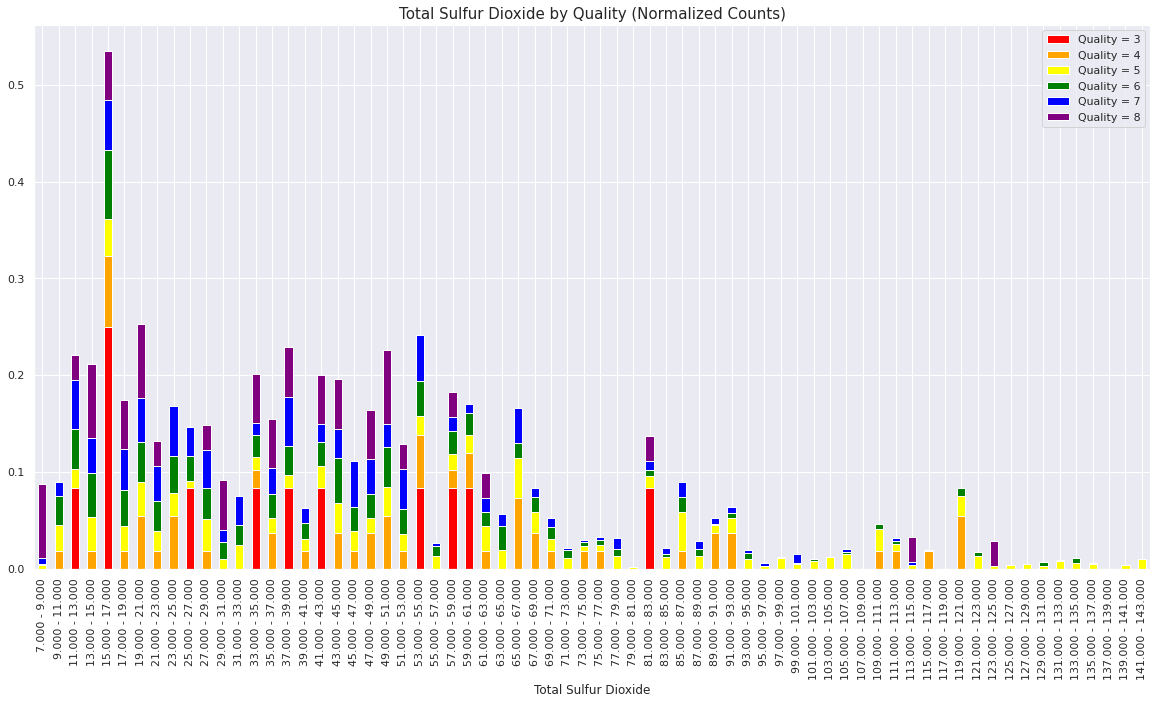

In [22]:
bin_defs = []
labels = []
z = 7
step = 2.
for x in range(int(z), 75):
    bin_defs.append([z, z + step])
    labels.append("{:.3f} - {:.3f}".format(z, z + step))
    z += step
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))

sns.set_style('darkgrid')
sns.set_palette('Set2')

tdf = pd.DataFrame(
    {
        'Label': labels,
        'Quality = 3': bin_data(train[(train["quality"] == 3)]["total sulfur dioxide"], bin_defs),
        'Quality = 4': bin_data(train[(train["quality"] == 4)]["total sulfur dioxide"], bin_defs),
        'Quality = 5': bin_data(train[(train["quality"] == 5)]["total sulfur dioxide"], bin_defs),
        'Quality = 6': bin_data(train[(train["quality"] == 6)]["total sulfur dioxide"], bin_defs),
        'Quality = 7': bin_data(train[(train["quality"] == 7)]["total sulfur dioxide"], bin_defs),
        'Quality = 8': bin_data(train[(train["quality"] == 8)]["total sulfur dioxide"], bin_defs),
    }
)

_ = tdf.set_index('Label').plot(kind='bar', stacked=True, color=["red", "orange", "yellow", "green", "blue", "purple"], ax=ax)
_ = ax.set_title("Total Sulfur Dioxide by Quality (Normalized Counts)", fontsize=15)
_ = ax.set_ylabel("")
_ = ax.set_xlabel("Total Sulfur Dioxide")

Okay, so class separation is more apparent when there are total sulfur dioxide concentrations above 71 or so. Let's take a look for a moment at free sulfur dioxide. Since it doesn't really have a correlation to quality, it's likely that the picture will be messy in terms of class separation.

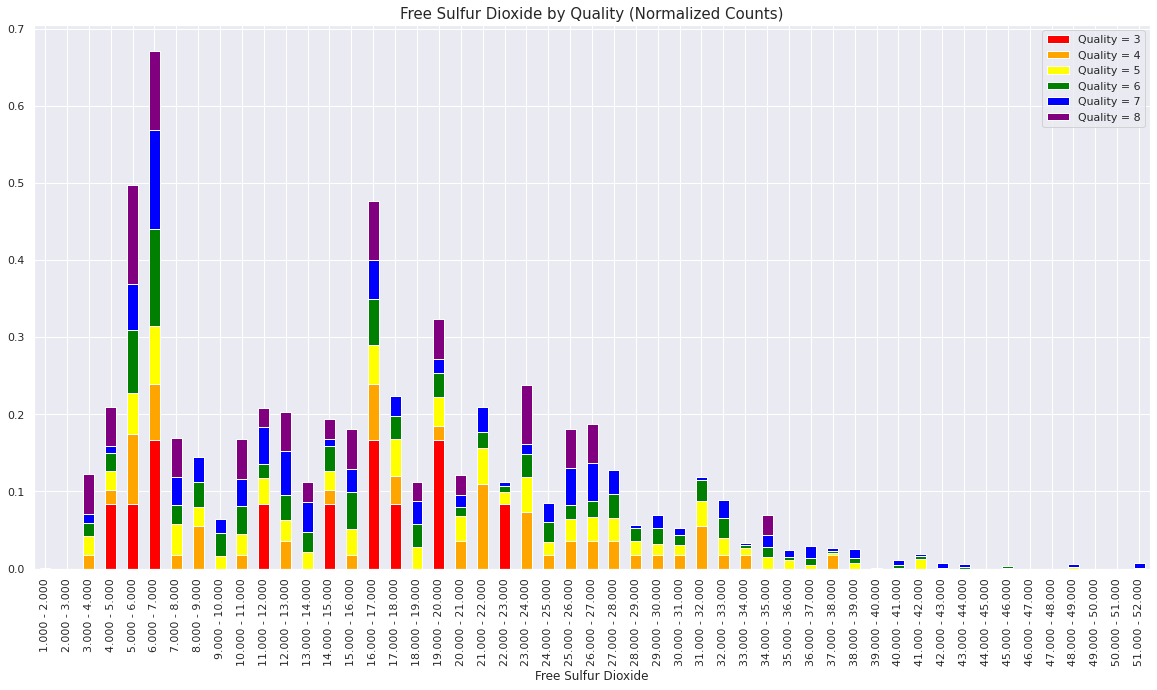

In [23]:
bin_defs = []
labels = []
z = 1
step = 1.
for x in range(int(z), 52):
    bin_defs.append([z, z + step])
    labels.append("{:.3f} - {:.3f}".format(z, z + step))
    z += step
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))

sns.set_style('darkgrid')
sns.set_palette('Set2')

tdf = pd.DataFrame(
    {
        'Label': labels,
        'Quality = 3': bin_data(train[(train["quality"] == 3)]["free sulfur dioxide"], bin_defs),
        'Quality = 4': bin_data(train[(train["quality"] == 4)]["free sulfur dioxide"], bin_defs),
        'Quality = 5': bin_data(train[(train["quality"] == 5)]["free sulfur dioxide"], bin_defs),
        'Quality = 6': bin_data(train[(train["quality"] == 6)]["free sulfur dioxide"], bin_defs),
        'Quality = 7': bin_data(train[(train["quality"] == 7)]["free sulfur dioxide"], bin_defs),
        'Quality = 8': bin_data(train[(train["quality"] == 8)]["free sulfur dioxide"], bin_defs),
    }
)

_ = tdf.set_index('Label').plot(kind='bar', stacked=True, color=["red", "orange", "yellow", "green", "blue", "purple"], ax=ax)
_ = ax.set_title("Free Sulfur Dioxide by Quality (Normalized Counts)", fontsize=15)
_ = ax.set_ylabel("")
_ = ax.set_xlabel("Free Sulfur Dioxide")

As we can see, there is some class separation above 35, but for the most part, the bulk of the classes are mashed together at lower values. We may be able to leverage a combination of total sulfur dioxide and free sulfur dioxide to get better class separation. Since free sulfur dioxide is a component of total sulfur dioxide, we should divide the two.

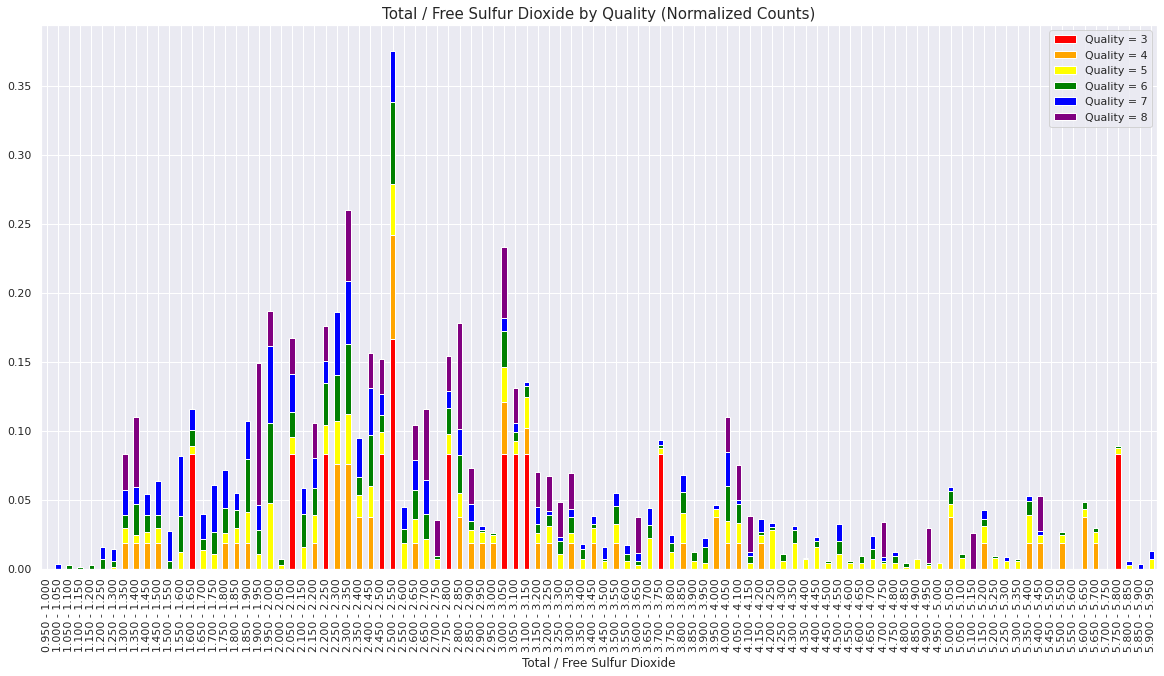

In [24]:
bin_defs = []
labels = []
z = 0.95
step = 0.05
for x in range(int(z), 100):
    bin_defs.append([z, z + step])
    labels.append("{:.3f} - {:.3f}".format(z, z + step))
    z += step
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))

sns.set_style('darkgrid')
sns.set_palette('Set2')

tdf = pd.DataFrame(
    {
        'Label': labels,
        'Quality = 3': bin_data(train[(train["quality"] == 3)]["total sulfur dioxide"] / train[(train["quality"] == 3)]["free sulfur dioxide"], bin_defs),
        'Quality = 4': bin_data(train[(train["quality"] == 4)]["total sulfur dioxide"] / train[(train["quality"] == 4)]["free sulfur dioxide"], bin_defs),
        'Quality = 5': bin_data(train[(train["quality"] == 5)]["total sulfur dioxide"] / train[(train["quality"] == 5)]["free sulfur dioxide"], bin_defs),
        'Quality = 6': bin_data(train[(train["quality"] == 6)]["total sulfur dioxide"] / train[(train["quality"] == 6)]["free sulfur dioxide"], bin_defs),
        'Quality = 7': bin_data(train[(train["quality"] == 7)]["total sulfur dioxide"] / train[(train["quality"] == 7)]["free sulfur dioxide"], bin_defs),
        'Quality = 8': bin_data(train[(train["quality"] == 8)]["total sulfur dioxide"] / train[(train["quality"] == 8)]["free sulfur dioxide"], bin_defs),
    }
)

_ = tdf.set_index('Label').plot(kind='bar', stacked=True, color=["red", "orange", "yellow", "green", "blue", "purple"], ax=ax)
_ = ax.set_title("Total / Free Sulfur Dioxide by Quality (Normalized Counts)", fontsize=15)
_ = ax.set_ylabel("")
_ = ax.set_xlabel("Total / Free Sulfur Dioxide")

Now we can see some separation of classes. Very importantly, we're able to start sorting out quality 3 wines from the bulk of the others, which is important since they represent a rare case.

### Key Observations About Sulfur Dioxide

* On their own, total sulfur dioxide and free sulfur dioxide provide class separation.
* Engineered features that may provide better class separation include:
    * Total sulfur dioxide / free sulfur dioxide